In [1]:
from collections import defaultdict
from itertools import product
import math

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data_folder = 'data/PsychAD_freeze2_personalized_grpahs/processed/'

In [2]:
sns.set(style='white', palette='Accent')
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

# Functions

In [3]:
# Analyzing functions
def detect_changing_edges(edgelists):
    # Get binary edges
    binary_edgelists = {k: np.array(v)[:, :2] for k, v in edgelists.items() if len(v) > 0}

    # Filter to uniquely appearing edges (per stage)
    print('Detecting Appearing Edges...')
    binary_unique_edgelists = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 >= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists = {k: np.stack(v) for k, v in binary_unique_edgelists.items()}

    print()
    # Filter to uniquely disappearing edges (per stage)
    print('Detecting Vanishing Edges...')
    binary_unique_edgelists_rev = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 <= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists_rev[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists_rev = {k: np.stack(v) for k, v in binary_unique_edgelists_rev.items()}
    
    return binary_unique_edgelists, binary_unique_edgelists_rev

def print_edges(edgelists):
    for i, (k, v) in enumerate(edgelists.items()):
        if i != 0:
            print()
        print(f'Braak: {k}')
        print('Top TFs: ', end='')
        genes, counts = np.unique(v[:, 0], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()
        print('Top TGs: ', end='')
        genes, counts = np.unique(v[:, 1], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()
        
def load_edgelists(prefix, suffix, possible_values=[f'{i:.1f}' for i in range(7)]):
    edgelists = {}
    for stage in possible_values:
        try:
            edgelists[stage] = pd.read_csv(prefix + stage + suffix, index_col=0)
        except:
            edgelists[stage] = pd.DataFrame(columns=['TF', 'TG', 'coef'])
        
    return edgelists

def analyze_braak(edgelists):
    bue, buer = detect_changing_edges(edgelists)
    print('\n' + 30*'-' + '\n')
    print('Appearing Edges...')
    print_edges(bue)
    print('\n' + 30*'-' + '\n')
    print('Vanishing Edges...')
    print_edges(buer)
    
    return edgelists, bue, buer

In [4]:
# Plotting functions
def format_dic(counts_dic):
    # Get all genes
    genes = []
    for k, v in counts_dic.items():
        genes += list(v[0])
    genes = np.unique(genes)

    # Format values
    genes_over_braak = defaultdict(lambda: [])
    for k, v in counts_dic.items():
        for gene in genes:
            count = v[1][np.argwhere(v[0] == gene)]
            if len(count) > 0:
                count = count[0][0]
            else:
                count = 0
            genes_over_braak[gene].append(count)
    genes_over_braak = dict(genes_over_braak)
    
    return genes_over_braak

def get_counts(edgelists):
    tf_counts = {}
    tg_counts = {}
    for k, v in edgelists.items():
        tf_counts[k] = np.unique(v['TF'], return_counts=True)  # val, count
        tg_counts[k] = np.unique(v['TG'], return_counts=True)
    tf_counts = format_dic(tf_counts)
    tg_counts = format_dic(tg_counts)
    
    return tf_counts, tg_counts

def plot_count_averages(counts_list, values, title=None, ylabel='Count', possible_values=[f'{i:.1f}' for i in range(7)]):
    df_concat = None
    for counts, value in zip(counts_list, values):
        # Plot average lines
        if len(list(counts.items())) == 0:
            continue
        average_line = np.zeros(len(list(counts.items())[0][1]))
        average_counts = np.zeros(len(list(counts.items())[0][1]))
        for k, v in counts.items():
            # Instead of 0, leave unfilled
            npv = np.array(v)
            # Add to average line
            average_line += npv
            average_counts += 1. * (npv != 0)
        plt.plot(
            np.array(range(len(v))), 
            average_line/average_counts, 
            lw=3, 
            path_effects=[pe.Stroke(linewidth=6, foreground='black'), pe.Normal()],
            label='_nolegend_',
            zorder=1,
        )

        # Make boxplots
        df = pd.DataFrame(counts)
        df = df.reset_index()
        df = df.rename(columns={'index': 'strat'})
        df = df.melt(id_vars='strat')
        df['feature_value'] = value
        # Drop zero values
        df = df.loc[~(df['value']==0)]
        if df_concat is not None:
            df_concat = pd.concat([df_concat, df])
        else:
            df_concat = df
    sns.boxplot(df_concat, x='strat', y='value', hue='feature_value')

    # Formatting
    plt.yscale('log')
    plt.xlabel('State')
    plt.xticks(ticks=np.arange(len(possible_values)), labels=possible_values)
    plt.ylabel(ylabel)
    plt.title(title)

    # Legend with no title
    plt.legend()
    # handles, labels = plt.gca().get_legend_handles_labels()
    # plt.gca().legend(handles=handles[1:], labels=labels[1:])

# Analysis

In [6]:
# Cur - Current
# Hx - Historical/Ever Seen
feature_dict = {
    'Sex': 'Sex',
    'nps_PsychoAgiCurValue': 'Psychomotor Agitation',
    'nps_PsychoAgiHxValue': 'Historical Psychomotor Agitation',
    'nps_PsychoRetardCurValue': 'Psychomotor Retardation',
    'nps_PsychoRetardHxValue': 'Historical Psychomotor Retardation',
    'nps_RumCurValue': 'Ruminations',
    'nps_RumHxValue': 'Historical Ruminations',
}
key_MF = [
    'Sex',
]
value_MF = [
    'Male', 'Female',
]
key_TF = [
    'nps_PsychoAgiCurValue', 'nps_PsychoAgiHxValue',
    'nps_RumCurValue', 'nps_RumHxValue',
    'nps_PsychoRetardCurValue', 'nps_PsychoRetardHxValue',
    'nps_FatCurValue', 'nps_FatHxValue',
]
value_TF = ['True', 'False']
key_01 = [
    'HippoLewyValue',
    'EntorLewyValue',
    'AmygLewyValue',
    'MidGliosisValue', 'MidLewyValue',
    'SupGliosisValue', 'SupLewyValue',
    'InfGliosisValue', 'InfLewyValue',
    'OcciGliosisValue', 'OcciLewyValue',
    'LewyDorsalVValue',
]
value_01 = ['0.0', '1.0']
key_05 = [
    'HippoPlaquesValue', 'HippoPlaquesWCoresValue', 'HippoTanglesValue',
    'EntorPlaquesValue', 'EntorPlaquesWCoresValue', 'EntorTanglesValue',
    'AmygPlaquesValue', 'AmygPlaquesWCoresValue', 'AmygTanglesValue',
    'MidPlaquesValue', 'MidPlaquesWCoresValue',
    'SupPlaquesValue', 'SupPlaquesWCoresValue',
    'InfPlaquesValue', 'InfPlaquesWCoresValue', 
    'OcciPlaquesValue', 'OcciPlaquesWCoresValue',
]
value_05 = ['0.0', '1.0', '3.0', '5.0']
value_dict = {
    k: v
    for k, v in zip(
        key_MF
        + key_TF
        + key_01
        + key_05
        ,
        len(key_MF)*[value_MF]
        + len(key_TF)*[value_TF]
        + len(key_01)*[value_01]
        + len(key_05)*[value_05]
    )
}
other_entries = {
    'BRAAK_AD': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
}
contrasts = pd.read_csv(data_folder + '../contrasts.csv', low_memory=False)
contrast_titles = {
    'c01x': [s for s in np.unique(contrasts['c01x'].astype(str)) if s != 'nan'],
    'c02x': [s for s in np.unique(contrasts['c02x'].astype(str)) if s != 'nan'],
    'c03x': [s for s in np.unique(contrasts['c03x'].astype(str)) if s != 'nan'],
    'c06x': [s for s in np.unique(contrasts['c06x'].astype(str)) if s != 'nan'],
    'c11x': [s for s in np.unique(contrasts['c11x'].astype(str)) if s != 'nan'],
}
value_dict.update(other_entries)
value_dict.update(contrast_titles)
# for k in value_dict.keys():
#     print(f'[\'{k}\'], ', end='')

# Params
cell_type = 'Glial'  # EN Endo Glial Immune IN Mural None
stratify_feature = 'HippoPlaquesValue'  # 'nps_PsychoAgiCurValue', 'nps_PsychoRetardCurValue', 'HippoPlaquesValue', 'BRAAK_AD'
feature = 'c11x'

C:\Users\nck\AppData\Local\Temp\ipykernel_20216\55529124.py:50: RuntimeWarning: invalid value encountered in divide
  average_line/average_counts,
C:\Users\nck\AppData\Local\Temp\ipykernel_20216\55529124.py:50: RuntimeWarning: invalid value encountered in divide
  average_line/average_counts,


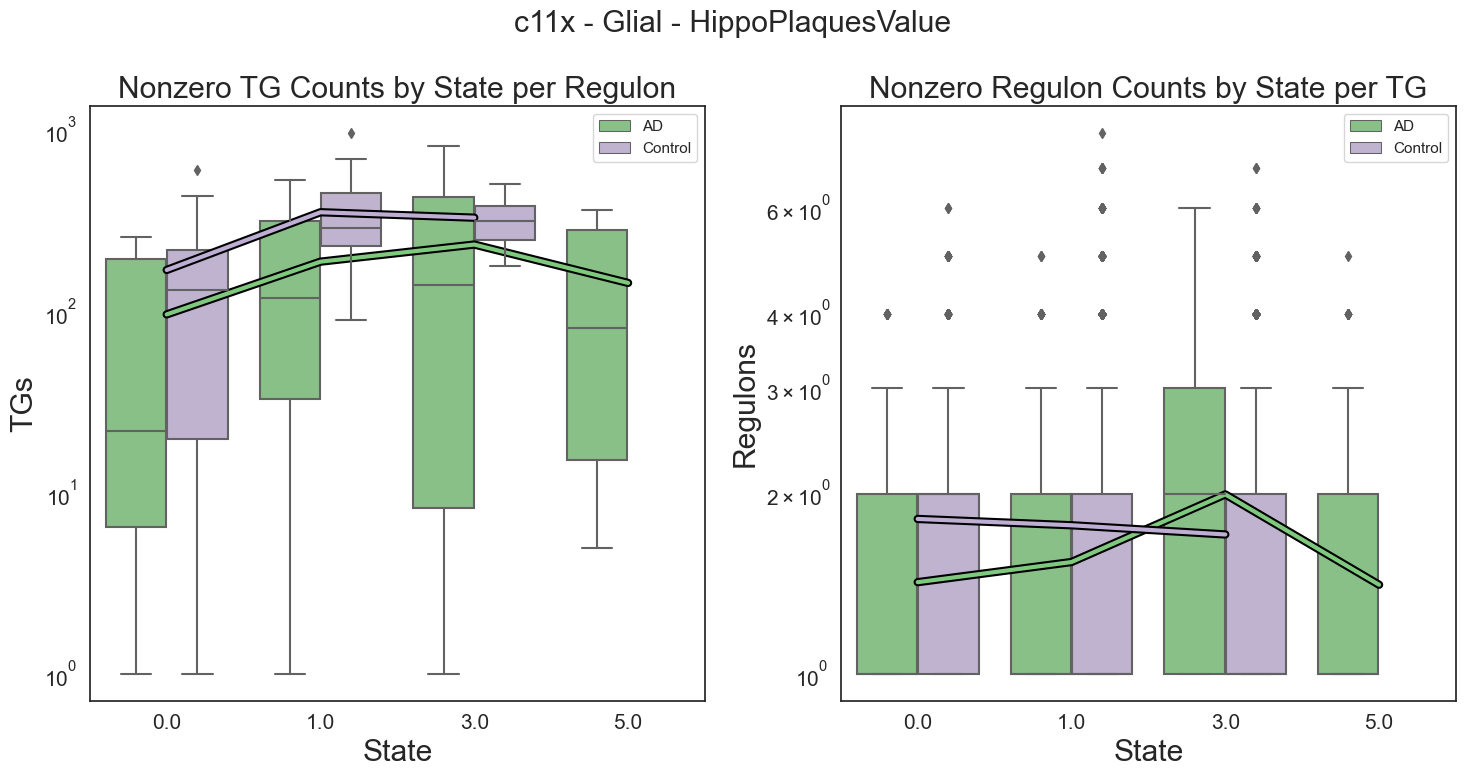

In [7]:
# Plot barplot and mean lines
def counts_generator():
    for value in value_dict[feature]:
        edgelists = load_edgelists(
            data_folder + f'grn_{f"{cell_type}_" if cell_type is not None else ""}{stratify_feature}_',
            f'_{feature}_{value}.csv',
            possible_values=value_dict[stratify_feature])
        tf_counts, tg_counts = get_counts(edgelists)
        yield tf_counts, tg_counts

def tf_counts_generator():
    for tf_counts, _ in counts_generator():
        yield tf_counts

def tg_counts_generator():
    for _, tg_counts in counts_generator():
        yield tg_counts

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle(
    f'{feature} - '
    f'{f"{cell_type} - " if cell_type is not None else ""}'
    f'{feature_dict[stratify_feature] if stratify_feature in feature_dict else stratify_feature}'
)
plt.sca(axs[0])
plot_count_averages(
    tf_counts_generator(),
    value_dict[feature],
    title='Nonzero TG Counts by State per Regulon',
    ylabel='TGs',
    possible_values=value_dict[stratify_feature],
)
plt.sca(axs[1])
plot_count_averages(
    tg_counts_generator(),
    value_dict[feature],
    title='Nonzero Regulon Counts by State per TG',
    ylabel='Regulons',
    possible_values=value_dict[stratify_feature],
)
plt.tight_layout()
plt.savefig(
    data_folder
    + '_'.join([i for i in [cell_type, stratify_feature, feature] if i])
    +'.svg', format='svg')

In [8]:
for i, value in enumerate(value_dict[feature]):
    if i != 0:
        print(f'\n\n{30*"-"}\n\n')
    print(f'{feature}: {value}')
    edgelists = load_edgelists(
        data_folder + f'grn_{f"{cell_type}_" if cell_type is not None else ""}{stratify_feature}_',
        f'_{feature}_{value}.csv',
        possible_values=value_dict[stratify_feature])
    analyze_braak(edgelists)


c11x: AD
Detecting Appearing Edges...
Braak: 0.0 (1067)
Braak: 1.0 (2)
Braak: 3.0 (4)
Braak: 5.0 (0)

Detecting Vanishing Edges...
Braak: 0.0 (0)
Braak: 1.0 (0)
Braak: 3.0 (25)
Braak: 5.0 (1158)

------------------------------

Appearing Edges...
Braak: 0.0
Top TFs:  SOX10 MXI1 SOX8 SREBF1 ELF1 FOXN2 SREBF2 FOXO1 PBX3 KDM5A NFE2L2
Top TGs:  FBXL7 PLEKHB1 LRRC1 SCD5 FAM13C CDK19 DYSF TLE4 HHIP MEIS2 CREB5 RHOU CLIP4 OLIG2 SEMA3B SEMA5A SEMA6A GPRC5B GNAO1 B3GAT1

Braak: 1.0
Top TFs:  JUND
Top TGs:  PLP1 PRNP

Braak: 3.0
Top TFs:  ELK3 IRF1
Top TGs:  BCL2L14 FTL RPL10 STAT1

------------------------------

Vanishing Edges...
Braak: 3.0
Top TFs:  FOXO1 IRF1
Top TGs:  BMPR1B STAT1 SOX9 SLC16A9 SH3PXD2B RNF182 RFX4 PREX2 PRDM16 PLSCR4 PLEKHG1 STK33 PHF21B PAX6 PARD3B NACC2 ITPKB GJA1 FAT1 EYA2

Braak: 5.0
Top TFs:  MXI1 SOX10 ELF1 SOX8 SREBF1 JUND SREBF2 ELK3
Top TGs:  PTMA CLDND1 AATK SUN2 CSRP1 CREB5 FAM102A NKX6-2 SCD KCNJ10 PLEKHG3 NAPEPLD REEP3 SHROOM4 UGT8 NDRG1 SLAIN1 USP54 BCAS1 TSC